In [1]:
!pip install rasterio
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 934.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=85a04991bde6ff55d529ce70853957970fc101d5a29a6ebecfa01072bdf9b917
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import rasterio
from rasterio.plot import show

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import randint, uniform



##Funciones

### Calcula Métricas

In [4]:
def calcula_metricas(nombre_modelo, etiquetas_test, etiquetas_predichas):
    global df_metrics
    accuracy = accuracy_score(etiquetas_test, etiquetas_predichas)

    # Crear un DataFrame con el nuevo dato y luego asignar a df_metrics
    nuevo_dato = pd.DataFrame({'Modelo': [nombre_modelo], 'Accuracy': [accuracy]})
    df_metrics = pd.concat([df_metrics, nuevo_dato], axis=0)
    # Guardar datos en archivo
    df_metrics.to_csv('resultados.csv', index=False)
    # Imprimir los resultados formateados
    print(df_metrics)

### Mostrar imágen clasificada

In [5]:
# Obtener dimensiones de la matriz
def mostrar_img_clasificada(imagen_clasificada, modelo, rgb_image, metadata_original):
  img_etiqueta = imagen_clasificada
  # Crear una copia de la imagen RGB para modificarla
  imagen = rgb_image.copy()

  rows, cols = img_etiqueta.shape


  rows, cols = img_etiqueta.shape

  # Recorrer la matriz e imprimir los valores de cada píxel
  for row in range(rows):
      for col in range(cols):
          pixel_value = img_etiqueta[row, col]
          if pixel_value == 1:
            imagen[0, row, col] = 50


  # Mostrar la imagen RGB e  imágen clasificada
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  show(rgb_image, ax=axs[0], title='Imagen a Clasificar')
  show(imagen, ax=axs[1], title='Imagen clasificada')
  #Guarda Imagen clasificada
  fd_imagen_satelital_clasificada = r'/content/drive/MyDrive/Sentinel_Vinciguerra/2022/imagen_clasificada_'+ modelo + '.tif'
  # Abre el archivo destino para escritura

  with rasterio.open(fd_imagen_satelital_clasificada, 'w', **metadata_original) as dst:
     # Escribe los datos de la imagen en el archivo
     dst.write(imagen)

### Calcular área del glaciar

In [47]:
def calcular_porcentaje_hielo(imagen_clasificada):
    unique_values, counts = np.unique(imagen_clasificada, return_counts=True)
    total_pixels = np.sum(counts)

    for value, count in zip(unique_values, counts):
        if value == 1:
            percentage = (count / total_pixels) * 100
            cantidad = count

    return percentage, cantidad * 10

###Lectura de Imagenes Satelitales,  Filtros y Etiquetas:  Glaciar Vinciguerra
####Año 2020 al 2022.  
###Epoca estival.


In [10]:
directorio_coberturas = r"/content/drive/MyDrive/Sentinel_Vinciguerra"

In [11]:
pixeles = []
ndsi    = []
etiquetas = []
for anio in range(2019, 2023):
    carpeta = directorio_coberturas + '/' + str(anio)
    print(carpeta)
    for muestra in range(1, 2):
        archivo = carpeta + '/RGB_' + str(muestra) + '.tif'
        archivo_ndsi = carpeta + '/NDSI_' + str(muestra) + '.tif' #por el momento reemplazo con image con todos los CANALES a NDSI
        archivo_etiquetas = carpeta + '/' +str(anio)+'-etiquetado_' + str(muestra) + '.tif'
        archivo_total = carpeta + '/Total_'+ str(muestra) + '.tif'

        with rasterio.open(archivo) as muestra_entrenamiento:
            #Imagen RGB
            imagen = muestra_entrenamiento.read()
            imagen_satelital = imagen

            #Imagen NDSI
            img_ndsi = rasterio.open(archivo_ndsi)
            img_ndsi = img_ndsi.read()
            ndsi_satelital = img_ndsi
            img_ndsi = img_ndsi.reshape((img_ndsi.shape[0], -1)).T
            ndsi.extend(img_ndsi)

            #Todos los canales
            img_total = rasterio.open(archivo_total)
            img_total = img_total.read()
            img_total = img_total.reshape((img_total.shape[0], -1)).T
            pixeles.extend(img_total)

            #Etiquetas
            tif = rasterio.open(archivo_etiquetas)
            img_tif = tif.read()
            imagen_tif = img_tif
            img_tif = img_tif.reshape((img_tif.shape[0], -1)).T
            etiquetas.extend(img_tif)

/content/drive/MyDrive/Sentinel_Vinciguerra/2019
/content/drive/MyDrive/Sentinel_Vinciguerra/2020
/content/drive/MyDrive/Sentinel_Vinciguerra/2021
/content/drive/MyDrive/Sentinel_Vinciguerra/2022


### Lectura de imagen a clasificar
### Vinciguerra 2023

In [12]:
cimagen =  '/content/drive/MyDrive/Sentinel_Vinciguerra/2023/RGB_1.tif'
#cimagen_ndsi =  '/content/drive/MyDrive/Sentinel_Vinciguerra/2023/NDSI_1.tif'
cimagen_total =  '/content/drive/MyDrive/Sentinel_Vinciguerra/2023/Total_1.tif'

cimagen_satelital = rasterio.open(cimagen)
imagen_a_clasificar = cimagen_satelital.read()
rgb_image = imagen_a_clasificar
metadata_original = cimagen_satelital.profile
cimagen_total = rasterio.open(cimagen_total)
cimagen_total = cimagen_total.read()


### Inspección de Datos

#### Imagenes, filtros y etiquetas de entrenamiento

In [13]:
pixeles = np.nan_to_num(pixeles, nan=0)
ndsi = np.nan_to_num(ndsi, nan=0)


In [14]:
print(f" Shape Imagen Original: {imagen_satelital.shape}")
print(f" Imagen Reshape: {imagen.shape}")
print(f" Pixeles: {len(pixeles)}")
print(f" Canales: {pixeles[300]}")
print(f" NDSI: {ndsi[300]}")

 Shape Imagen Original: (3, 155, 148)
 Imagen Reshape: (3, 155, 148)
 Pixeles: 91760
 Canales: [1270 1045  873  841  910  937  949  894  981  497   19 1576 1250    0
    0    0]
 NDSI: [-0.28705594]


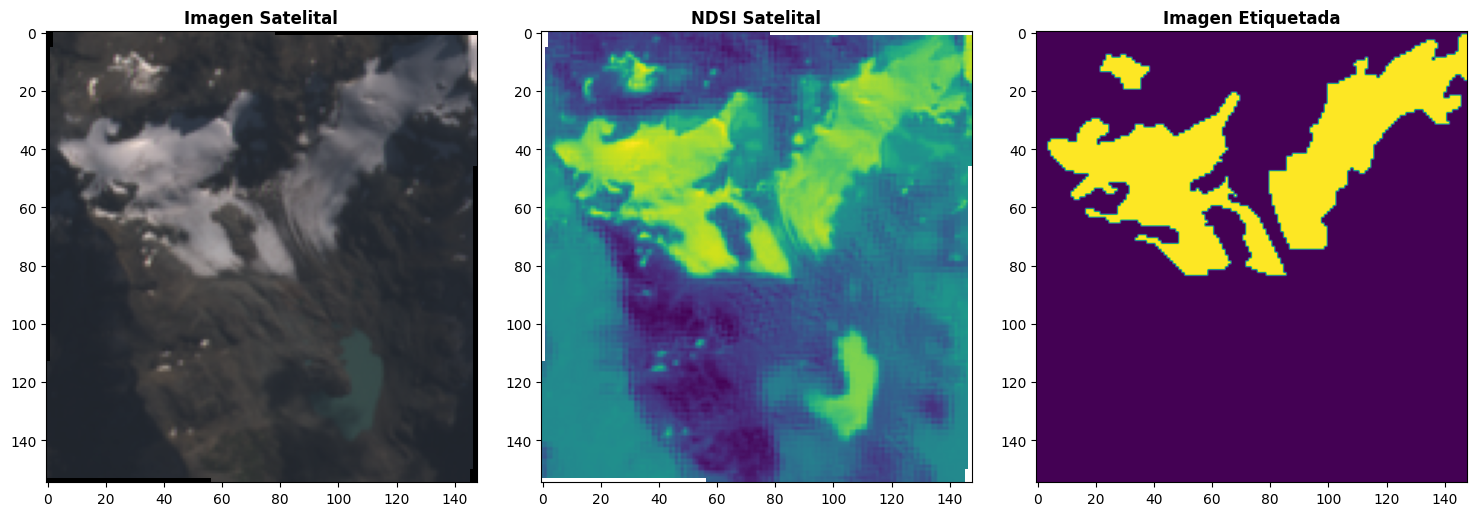

In [15]:
# Mostrar última imágen satelital , filtro ndsi e imágen etiquetada
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

show(imagen_satelital, ax=axs[0], title='Imagen Satelital')
show(ndsi_satelital, ax=axs[1], title='NDSI Satelital')
show(imagen_tif, ax=axs[2], title='Imagen Etiquetada')

# Ajustar el diseño
plt.tight_layout()
plt.show()

#### Imagen a Clasificar

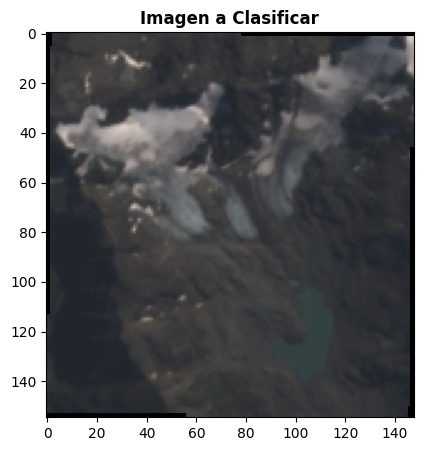

<Axes: title={'center': 'Imagen a Clasificar'}>

In [16]:
# Mostrar última imágen satelital , filtro ndsi e imágen etiquetada
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

show(rgb_image, title='Imagen a Clasificar')
#show(cimagen_ndsi, ax=axs[1], title='NDSI Satelital')

###Acondicionar datos para entrenamiento

In [17]:
#Array de entrenamiento: Combinar los valores de pixeles (RGB) y ndsi (N)
pixeles = np.array(pixeles)
ndsi = np.array(ndsi)
etiquetas = np.array(etiquetas)
#
ndsi_aux = np.array(ndsi).reshape(-1, 1)  # Convertir a columna
# Combinar los valores de pixeles (RGB) y ndsi (N)
#combinados = np.hstack((pixeles, ndsi))
#prueba de bandas
#indices_bandas_filtradas = [3, 2, 1, 5, 6, 10]  # Índices de las bandas en imagen_ndsi_a_clasificar
#ndsi = ndsi[:, indices_bandas_filtradas]
#hasta aca
combinados = pixeles

# La lista 'combinados' ahora tiene 4 canales (RGBN)
print(f"Datos de Entrenamiento imagen geo tiff : {combinados}")

Datos de Entrenamiento imagen geo tiff : [[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [1328 1107  995 ...    0    0    0]
 ...
 [2100 1776 1472 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [18]:
#pixeles_entrenamiento, pixeles_test, etiquetas_entrenamiento, etiquetas_test = train_test_split(pixeles, etiquetas, test_size = 0.20)
pixeles_entrenamiento, pixeles_test, etiquetas_entrenamiento, etiquetas_test = train_test_split(combinados, etiquetas, test_size = 0.20, stratify=etiquetas)

In [19]:
#Estandarizar
scaler = StandardScaler()
scaler.fit(pixeles_entrenamiento)
pixeles_entrenamiento = scaler.transform(pixeles_entrenamiento)
pixeles_test = scaler.transform(pixeles_test)
etiquetas_entrenamiento = etiquetas_entrenamiento.ravel()


#### Acondicionamiento datos para clasificación

In [20]:
imagen_a_clasificar = cimagen_total.reshape((cimagen_total.shape[0], -1)).T
imagen_a_clasificar = np.nan_to_num(imagen_a_clasificar, nan=0)
combinados_clasi = imagen_a_clasificar
imagen_a_clasificar = scaler.transform(combinados_clasi)

###Inicialización Métricas

In [21]:
df_metrics = pd.DataFrame({
    'Modelo': [],
    'Accuracy': []
})


## KNN

### Entrenamiento

In [22]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(pixeles_entrenamiento, etiquetas_entrenamiento)


KNeighborsClassifier(n_neighbors=2)

In [23]:
etiquetas_predichas = knn.predict(pixeles_test)
calcula_metricas('KNN', etiquetas_test, etiquetas_predichas)

  Modelo  Accuracy
0    KNN  0.973954


In [24]:
import pickle
# Guardar el modelo en un archivo usando pickle
filename = 'modelo_knn.pkl'
with open(filename, 'wb') as file:
    pickle.dump(knn, file)

###Clasificación

In [25]:
imagen_clasificada_knn = knn.predict(imagen_a_clasificar)

In [26]:
print(imagen_clasificada_knn)
print(np.unique(imagen_clasificada_knn))
print("Valor del píxel : Cantidad")
unique_values, counts = np.unique(imagen_clasificada_knn, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

[0. 0. 0. ... 0. 0. 0.]
[0. 1.]
Valor del píxel : Cantidad
0.0: 19593
1.0: 3347


In [27]:
imagen_clasificada_knn = imagen_clasificada_knn.reshape((metadata_original['height'], metadata_original['width']))

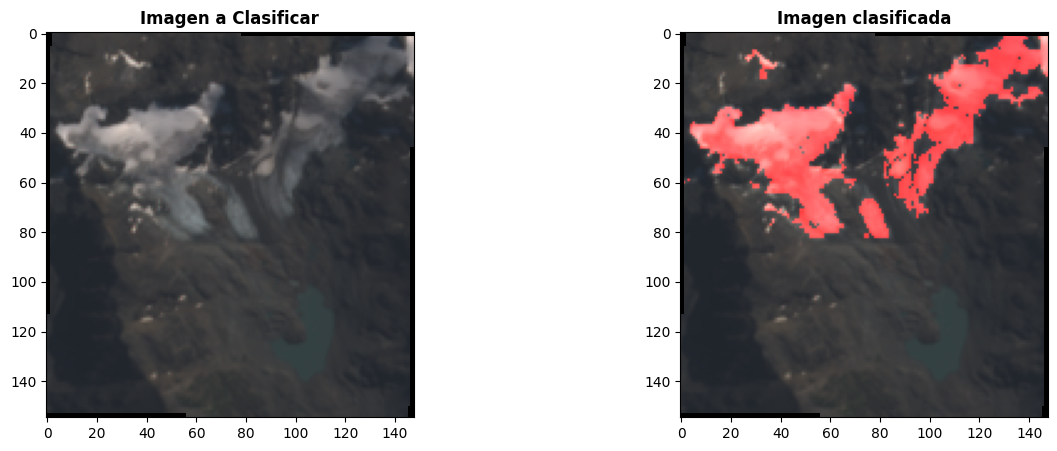

In [28]:
mostrar_img_clasificada (imagen_clasificada_knn, 'KNN', rgb_image,  metadata_original)

##Random Forest

### Entrenamiento

In [29]:
# Definir los parámetros que deseas probar en el Grid Search
param_grid = {
    'n_estimators': range(5, 20),  # Rango de valores para estimators
    'random_state': [42]  # Mantén el random_state constante para comparación
}

# Crear el modelo RandomForestClassifier
rf = RandomForestClassifier()

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Entrenar el GridSearchCV en los datos de entrenamiento
grid_search.fit(pixeles_entrenamiento, etiquetas_entrenamiento)

# Obtener el mejor modelo y sus hiperparámetros
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'n_estimators': 17, 'random_state': 42}


In [30]:
etiquetas_predichas =  best_rf.predict(pixeles_test)
calcula_metricas('Random Forest', etiquetas_test, etiquetas_predichas)

          Modelo  Accuracy
0            KNN  0.973954
0  Random Forest  0.980166


In [31]:
# Guardar el mejor modelo en un archivo Pickle
filename = 'model_rf.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_rf, file)

###Clasificación

In [32]:
imagen_clasificada_rf = best_rf.predict(imagen_a_clasificar)
imagen_clasificada_rf = imagen_clasificada_rf.reshape((metadata_original['height'], metadata_original['width']))

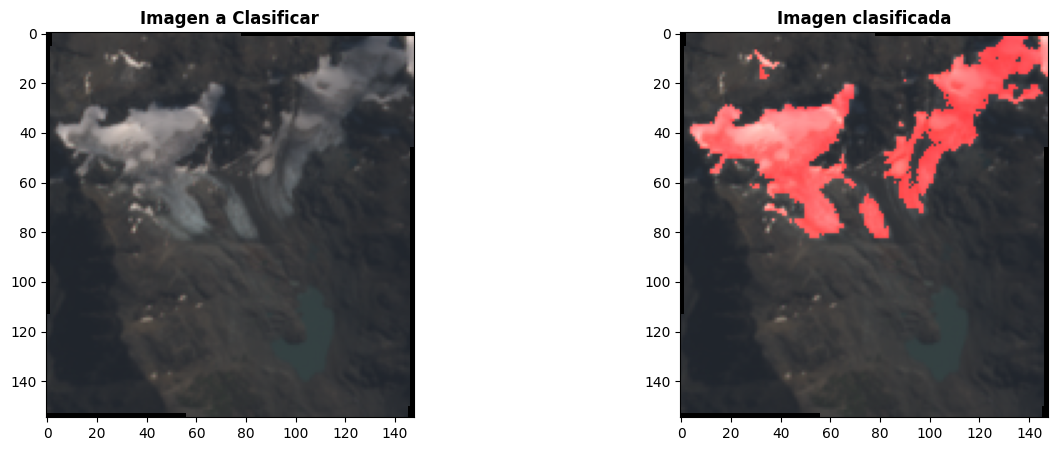

In [33]:
mostrar_img_clasificada (imagen_clasificada_rf, 'RF', rgb_image, metadata_original)

##XGBOOST

###Entrenamiento

In [34]:
# Definir un rango de valores para los hiperparámetros
param_dist = {
    'max_depth': randint(2, 4),  # Rango de profundidad máxima
    'n_estimators': randint(10, 20)  # Rango de número de estimadores
   # 'learning_rate': uniform(0.01, 0.3)  # Rango de tasa de aprendizaje
}

# Crear un clasificador XGBoost
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=2, random_state=42)


# Configurar RandomizedSearchCV con el clasificador y los hiperparámetros definidos
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, cv=3, random_state=42, n_jobs=-1)

# Ejecutar la búsqueda aleatoria en los datos de entrenamiento
random_search.fit(pixeles_entrenamiento, etiquetas_entrenamiento)

# Obtener los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo encontrado
best_model = random_search.best_estimator_


Mejores hiperparámetros: {'max_depth': 3, 'n_estimators': 19}


In [35]:
accuracy = accuracy_score(etiquetas_test, etiquetas_predichas)
calcula_metricas('XGBoost', etiquetas_test, etiquetas_predichas)

          Modelo  Accuracy
0            KNN  0.973954
0  Random Forest  0.980166
0        XGBoost  0.980166


In [36]:
filename = 'model_XGBoost.pkl'
with open(filename, 'wb') as file:
    pickle.dump((best_params, best_model), file)

##Clasificación

In [37]:
imagen_clasificada_xgb = best_model.predict(imagen_a_clasificar)
imagen_clasificada_xgb= imagen_clasificada_xgb.reshape((metadata_original['height'], metadata_original['width']))

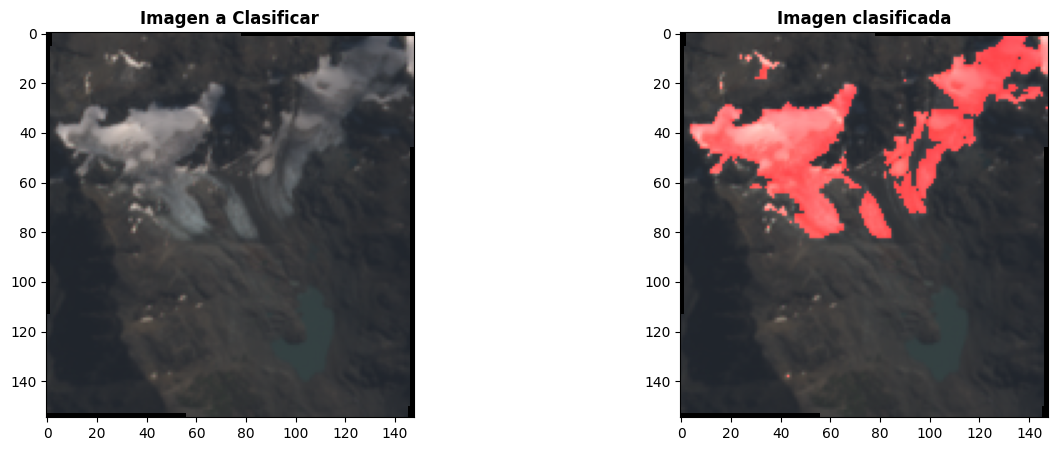

In [38]:
mostrar_img_clasificada (imagen_clasificada_xgb, 'RF', rgb_image, metadata_original)

##SVM

###Entrenamiento

In [40]:
svm = SVC(kernel = 'rbf', random_state = 42)
svm.fit(pixeles_entrenamiento, etiquetas_entrenamiento)

SVC(random_state=42)

In [41]:
#Validar accuracy del modelo entrenado
etiquetas_predichas = svm.predict(pixeles_test)
calcula_metricas('SVM', etiquetas_test, etiquetas_predichas)

          Modelo  Accuracy
0            KNN  0.973954
0  Random Forest  0.980166
0        XGBoost  0.980166
0            SVM  0.971447


In [42]:
# Guardar los hiperparámetros y el mejor modelo en un archivo Pickle
filename = 'model_snm.pkl'
with open(filename, 'wb') as file:
    pickle.dump((best_params, best_model), file)

###Clasificación

In [43]:
imagen_clasificada_svm = svm.predict(imagen_a_clasificar)
imagen_clasificada_svm = imagen_clasificada_rf.reshape((metadata_original['height'], metadata_original['width']))

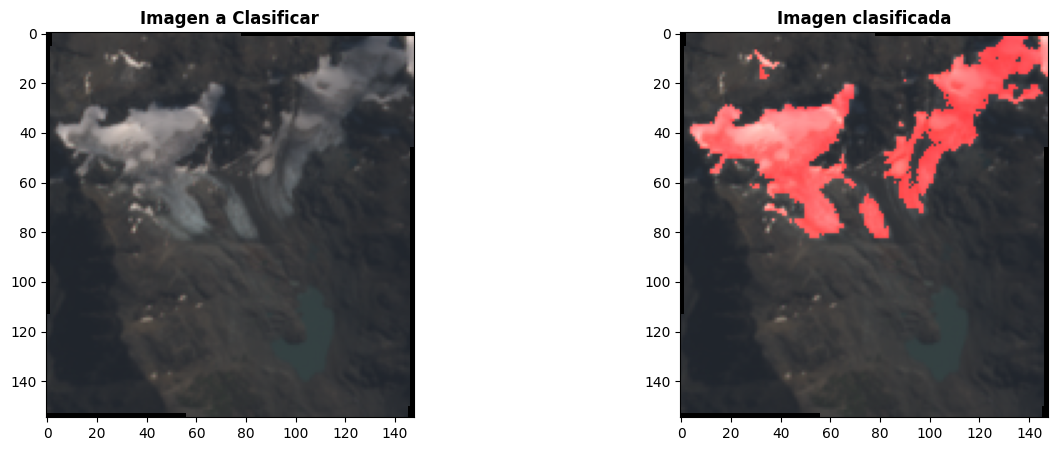

In [44]:
mostrar_img_clasificada (imagen_clasificada_svm, 'SVM',  rgb_image, metadata_original)

## TPOT (Tree-Based Pipeline Optimization Tool)
Herramienta de aprendizaje automático automatizada que se utiliza para la optimización de pipelines de machine learning. Desarrollada para  ayudar en la selección y ajuste de algoritmos de machine learning, así como en la configuración de los hiperparámetros asociados, de una manera automatizada y eficiente.

In [52]:
# Crear una instancia de TPOTClassifier y ajustarla a los datos de entrenamiento
tpot = TPOTClassifier(generations=3, population_size=10, verbosity=2)
tpot.fit(pixeles_entrenamiento, etiquetas_entrenamiento)

# Evaluar el modelo en el conjunto de prueba
accuracy = tpot.score(pixeles_test, etiquetas_test)
print("Accuracy:", accuracy)

# Exportar el código del mejor pipeline encontrado por TPOT
tpot.export('best_model.py')


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9809148795877596

Generation 2 - Current best internal CV score: 0.9809148795877596

Generation 3 - Current best internal CV score: 0.9809148795877596

Best pipeline: RandomForestClassifier(MinMaxScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=11, n_estimators=100)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9801656495204882


In [55]:
imagen_clasificada_tpot = tpot.predict(imagen_a_clasificar)
imagen_clasificada_tpot = imagen_clasificada_tpot.reshape((metadata_original['height'], metadata_original['width']))

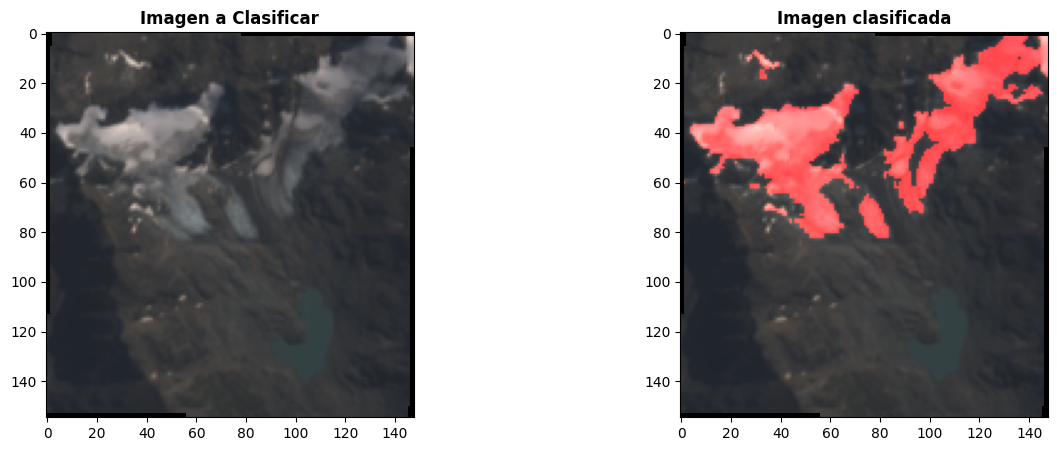

In [56]:
mostrar_img_clasificada (imagen_clasificada_tpot, 'TPOT',   rgb_image, metadata_original)

## Calcular la dimensión del glaciar

### Imagen Clasificada 2023:  Epoca estival

Modelo seleccionado tpot

In [ ]:
#tpot.predict(imagen_a_clasificar)

In [64]:
for anio in range(2019, 2023):
    carpeta = directorio_coberturas + '/' + str(anio)
    for muestra in range(1, 2):
        archivo_etiquetas = carpeta + '/' +str(anio)+'-etiquetado_' + str(muestra) + '.tif'

        with rasterio.open(archivo_etiquetas) as tif:
            img_tif = tif.read()
            img_tif = img_tif.reshape((img_tif.shape[0], -1)).T
            #Calculo porcentaje de cobertura
            porcentaje, metros = calcular_porcentaje_hielo(img_tif)
            print(f"Año: {anio:}, Porcentaje de hielo: {porcentaje:.2f}%, m2 de hielo: {metros:}")



Año: 2019, Porcentaje de hielo: 18.54%, m2 de hielo: 42540
Año: 2020, Porcentaje de hielo: 19.52%, m2 de hielo: 44780
Año: 2021, Porcentaje de hielo: 13.59%, m2 de hielo: 31180
Año: 2022, Porcentaje de hielo: 17.73%, m2 de hielo: 40680


##Imprimir Imagen Clasificada del 2023

In [67]:
porcentaje, metros = calcular_porcentaje_hielo(imagen_clasificada_tpot)
print(f"Año: {2023:}, Porcentaje de hielo: {porcentaje:.2f}%, m2 de hielo: {metros:}")


Año: 2023, Porcentaje de hielo: 15.17%, m2 de hielo: 34810


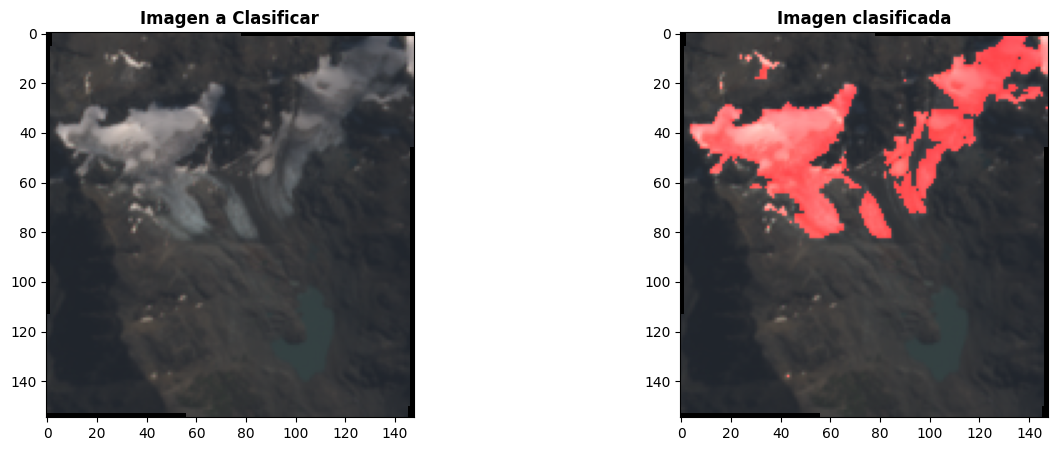

In [51]:
mostrar_img_clasificada (imagen_clasificada_tpot, 'RF', rgb_image, metadata_original)

In [50]:
porcentaje, metros = calcular_porcentaje_hielo(imagen_clasificada_knn)
print(f"Año: {2023:}, Porcentaje de hielo: {porcentaje:.2f}%, m2 de hielo: {metros:}")


Año: 2023, Porcentaje de hielo: 14.59%, m2 de hielo: 33470
